In [5]:
# # Core libraries
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import os
from pathlib import Path
from collections import defaultdict
from itertools import product
import pickle
from scipy.optimize import minimize_scalar
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')

# Data handling
from torch.utils.data import Sampler, DataLoader
import random

# Hugging Face libraries
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    TrainerCallback,
    TrainerState,
    TrainerControl,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    precision_recall_curve,
    precision_recall_fscore_support,
    f1_score,
)

# Multi-label stratified splitting
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# Metrics
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score, roc_auc_score

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Data 

## Load data

We load a dataset with two types of samples:
- **Random samples**: Unbiased data collection
- **Biased samples**: Oversampled rare classes to help with imbalance

The biased samples are only used for training, never for validation or testing.

In [17]:
DATA_PATH = r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\coding_trial\testData13052025.csv"
CATEGORIES_PATH = r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\data\categories_of_interest.txt"


df = pd.read_csv(DATA_PATH)
df = df.drop(columns='Unnamed: 0')

# Mark which samples were randomly collected vs. oversampled
# This is crucial to avoid testing on biased data
df['is_random'] = np.where(
    df.batch.isin(['batch1', 'batch2_m', 'batch2_s', 'batch2_l', 'batch2_j', 'batch3_l']),
    1,  # Random sample
    0   # Biased sample
)

df['paper_id'] = [i.split(".json")[0] for i in df.id.values]


with open(CATEGORIES_PATH, 'r') as file:
    cats = json.load(file)

print(f"Dataset shape: {df.shape}")
print(f"Number of categories: {len(cats)}")
print(f"Random samples: {(df['is_random'] == 1).sum()}")
print(f"Biased samples: {(df['is_random'] == 0).sum()}")

Dataset shape: (1845, 72)
Number of categories: 38
Random samples: 1497
Biased samples: 348


## Create Train/Validation/Test Split

We use a careful splitting strategy:
- **Test set (20%)**: Only random samples - for unbiased evaluation
- **Validation set (10%)**: Only random samples - for model selection
- **Training set (70% + biased)**: Random samples + ALL biased samples

This ensures our evaluation is unbiased while maximizing training data.

In [18]:
# Separate random and biased data
rand_df = df[df['is_random'] == 1]
biased_df = df[df['is_random'] == 0]

X_rand, y_rand = rand_df['displayed_text'], rand_df[cats]
X_bias, y_bias = biased_df['displayed_text'], biased_df[cats]

# First split: 80/20 for train+val/test from random data
msss_test = MultilabelStratifiedShuffleSplit(test_size=0.20, random_state=42, n_splits=1)
train_val_idx, test_idx = next(msss_test.split(X_rand, y_rand))

X_test, y_test = X_rand.iloc[test_idx], y_rand.iloc[test_idx]

# Second split: 87.5/12.5 for train/val from remaining (gives us 70/10/20 overall)
X_train_val, y_train_val = X_rand.iloc[train_val_idx], y_rand.iloc[train_val_idx]
msss_val = MultilabelStratifiedShuffleSplit(test_size=0.125, random_state=42, n_splits=1)
train_idx, val_idx = next(msss_val.split(X_train_val, y_train_val))

X_train_rand, y_train_rand = X_train_val.iloc[train_idx], y_train_val.iloc[train_idx]
X_val, y_val = X_train_val.iloc[val_idx], y_train_val.iloc[val_idx]

# Combine random training data with ALL biased data
X_train = pd.concat([X_train_rand, X_bias])
y_train = pd.concat([y_train_rand, y_bias])

# Calculate class frequencies (crucial for DB loss)
class_frequencies = y_train.sum(axis=0).values
print(f"\nDataset split:")
print(f"- Training: {len(X_train)} samples (including {len(X_bias)} biased)")
print(f"- Validation: {len(X_val)} samples (all unbiased)")
print(f"- Test: {len(X_test)} samples (all unbiased)")
print(f"\nClass frequencies in training set:")
print(f"- Min: {class_frequencies.min()}")
print(f"- Max: {class_frequencies.max()}")
print(f"- Mean: {class_frequencies.mean():.1f}")


Dataset split:
- Training: 1390 samples (including 348 biased)
- Validation: 151 samples (all unbiased)
- Test: 304 samples (all unbiased)

Class frequencies in training set:
- Min: 40
- Max: 1165
- Mean: 317.7


<Axes: >

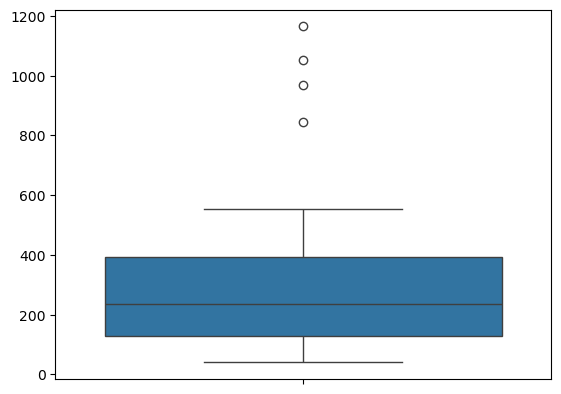

In [21]:
# plot the frequencies
from matplotlib import pyplot as plt
import seaborn as sns

sns.boxplot(class_frequencies)

In [22]:
# save the data for upload
# use this for LR and GPT as well

upload_data_scibert = {'training data':{'X_train': X_train, 'y_train':y_train, 'X_train_rand':X_train_rand, 'X_bias':X_bias, 'y_train_rand':y_train_rand, 'y_bias':y_bias, 'train_idx':train_idx},
              'validation data': {'X_val':X_val, 'y_val':y_val, 'val_idx':val_idx},
              'test data':{'X_test':X_test, 'y_test':y_test, 'test_idx':test_idx}, 
              'og_data': df,
              'class_frequencies':class_frequencies,
               'labels':cats
              }

with open("methods_paper_files/upload_data_scibert.pkl", "wb") as f:
    pickle.dump(upload_data_scibert, f)



## Create Label Mappings and HuggingFace Datasets

Convert our pandas DataFrames to HuggingFace Dataset format for easier processing.

In [23]:
# Create label mappings
labels = cats
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

# Convert to HuggingFace datasets
train_data = {'text': X_train.tolist(), 'labels': y_train.values.tolist()}
val_data = {'text': X_val.tolist(), 'labels': y_val.values.tolist()}
test_data = {'text': X_test.tolist(), 'labels': y_test.values.tolist()}

dataset = DatasetDict({
    'train': Dataset.from_dict(train_data),
    'validation': Dataset.from_dict(val_data),
    'test': Dataset.from_dict(test_data)
})


## Tokenization

We tokenize the text using the appropriate tokenizer for our mod. elWtest both scibert and distilbert. .
SciBERT is optimized for scientific text, while DistilBERT is faster and smaller.

In [24]:
# Choose model - SciBERT for scientific text or DistilBERT for general/faster training
MODEL_NAME = "allenai/scibert_scivocab_uncased"  # or "distilbert-base-uncased" for the lighter model

print(f"Loading tokenizer for {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_data(examples):

    # Tokenize text
    encoding = tokenizer(
        examples["text"],
        padding="max_length",    
        truncation=True,          # Truncate if longer than max_length
        max_length=512           # or lower for efficiency
    )
    
    encoding["labels"] = examples["labels"]
    
    return encoding

# Apply preprocessing
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=['text'])
encoded_dataset.set_format("torch")

Loading tokenizer for allenai/scibert_scivocab_uncased...


Map:   0%|          | 0/1390 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

Map:   0%|          | 0/304 [00:00<?, ? examples/s]

# 3. Sampling Strategy

Standard random sampling can lead to batches with only common classes.
Our custom sampler ensures each batch contains diverse classes, giving
rare classes more exposure during training.

In [26]:
class ClassAwareSampler(Sampler):
    """
    Custom sampler that ensures balanced class representation in each batch.
    
    How it works:
    1. For each epoch, shuffle all classes
    2. Go through classes in groups of batch_size
    3. For each class, randomly sample one instance that has that label
    4. This ensures every batch sees diverse classes, not just common ones
    
    Based on Huang et al. (2021) for multi-label classification.
    """
    def __init__(self, label_matrix, batch_size):
        """
        Args:
            label_matrix: numpy array [N, C] with binary labels
            batch_size: number of samples per batch
        """
        self.label_matrix = label_matrix
        self.batch_size = batch_size
        self.n_samples, self.n_classes = label_matrix.shape
        
        # Build mapping: class_id -> [sample indices that have this class]
        self.cls2idx = {}
        for c in range(self.n_classes):
            indices = np.where(label_matrix[:, c] == 1)[0].tolist()
            if indices:  # Only include classes that have at least one sample
                self.cls2idx[c] = indices
        
        self.classes = list(self.cls2idx.keys())
        print(f"ClassAwareSampler initialized:")
        print(f"  - {len(self.classes)} classes with samples")
        print(f"  - Batch size: {batch_size}")
        
    def __iter__(self):
        """Generate indices for one epoch."""
        indices = []
        
        # Shuffle classes for this epoch
        shuffled_classes = self.classes.copy()
        random.shuffle(shuffled_classes)
        
        # Process classes in chunks of batch_size
        for i in range(0, len(shuffled_classes), self.batch_size):
            batch_classes = shuffled_classes[i:i + self.batch_size]
            
            # For each class in this batch, sample one instance
            for cls in batch_classes:
                idx = random.choice(self.cls2idx[cls])
                indices.append(idx)
        
        # Continue sampling until we have enough for full epoch
        epoch_size = self.n_samples
        while len(indices) < epoch_size:
            random.shuffle(shuffled_classes)
            for cls in shuffled_classes:
                if len(indices) >= epoch_size:
                    break
                idx = random.choice(self.cls2idx[cls])
                indices.append(idx)
                
        return iter(indices[:epoch_size])
    
    def __len__(self):
        """Number of samples in one epoch."""
        return self.n_samples


# 4. Distribution Balanced Loss Implementation

Inspired by mostly [this paper](https://arxiv.org/abs/2109.04712), but also [this paper](https://link.springer.com/chapter/10.1007/978-3-030-58548-8_10) and [this post](https://www.kdnuggets.com/2023/03/multilabel-nlp-analysis-class-imbalance-loss-function-approaches.html). Just the custom loss is probably better than oversampling, because when you oversample sparse labels you also oversample common labels, which messes up that balance as well. We do use class aware sampling, such that each bach has at least one positive of each label (if necessary with oversampling), just like in Huang et al.

This is the core innovation for handling imbalanced multi-label classification.
The DB loss combines three techniques:

1. **Rebalanced Weighting**: Addresses label co-occurrence
2. **Focal Loss**: Focuses on hard-to-classify examples
3. **Negative-Tolerant Regularization**: Handles class ince. We experimented with label smoothing, but decided to stick to how the paper does itasses.

In [25]:
class DistributionBalancedLoss(nn.Module):
    """
    Distribution-Balanced (DB) loss from Wu & Huang (2020) and Huang et al. (2021)
    with backward-compatible keyword aliases:
        negative_tolerant_lambda → negative_lambda
        negative_tolerant_kappa  → negative_kappa
    """
    def __init__(self,
                 class_freq,
                 rebalance_alpha=0.1, rebalance_beta=10.0, rebalance_mu=0.7,
                 focal_gamma=2.0,
                 negative_lambda=2.0, negative_kappa=0.05,
                 label_smoothing=0.0,
                 **kwargs):                         # <- catch legacy names
        # --- map legacy keywords, if present ---
        if "negative_tolerant_lambda" in kwargs:
            negative_lambda = kwargs.pop("negative_tolerant_lambda")
        if "negative_tolerant_kappa" in kwargs:
            negative_kappa = kwargs.pop("negative_tolerant_kappa")

        # raise on any truly unknown kwarg
        if kwargs:
            unknown = ", ".join(kwargs.keys())
            raise TypeError(f"Unexpected keyword argument(s): {unknown}")

        super().__init__()

        # store class frequencies
        self.register_buffer("class_freq",
                             torch.tensor(class_freq, dtype=torch.float32))
        self.m = len(class_freq)

        # hyper-parameters
        self.alpha  = rebalance_alpha
        self.beta   = rebalance_beta
        self.mu     = rebalance_mu
        self.gamma  = focal_gamma
        self.lmbda  = negative_lambda
        self.kappa  = negative_kappa
        self.eps    = 1e-7
        self.label_smoothing = label_smoothing

        # negative-tolerant logit shift
        p_c = torch.clamp(self.class_freq / self.class_freq.sum(), 1e-7, 1-1e-7)
        self.register_buffer("v_i", -self.kappa * torch.log(p_c / (1 - p_c)))

    # ------------- helper functions (unchanged) -------------
    def _smooth(self, y):
        if self.label_smoothing <= 0:
            return y
        return y * (1 - self.label_smoothing) + 0.5 * self.label_smoothing

    def _rebalanced_weights(self, y):
        inv_n   = (1.0 / self.class_freq).unsqueeze(0)
        pos_m   = y > 0
        P_I     = (pos_m * inv_n / self.m).sum(1, keepdim=True) + self.eps
        P_C     = inv_n / self.m
        r_db    = P_C / P_I
        w       = self.alpha + torch.sigmoid(self.beta * (r_db - self.mu))
        return torch.where(pos_m, w, torch.ones_like(w))

    def forward(self, logits, y):
        y        = y.float()
        v_i      = self.v_i.to(logits.device)
        inv_l    = 1.0 / self.lmbda
        y_smooth = self._smooth(y)
        w        = self._rebalanced_weights(y).to(logits.device)

        # positives
        q_pos    = torch.sigmoid(logits - v_i)
        loss_pos = -w * ((1 - q_pos)**self.gamma) * (
                     y_smooth * torch.log(q_pos + self.eps) +
                     (1 - y_smooth) * torch.log(1 - q_pos + self.eps))

        # negatives
        q_neg    = torch.sigmoid(self.lmbda * (logits - v_i))
        loss_neg = -inv_l * (q_neg**self.gamma) * (
                     y_smooth * torch.log(q_neg + self.eps) +
                     (1 - y_smooth) * torch.log(1 - q_neg + self.eps))

        loss = torch.where(y > 0, loss_pos, loss_neg)
        return loss.mean()


# 5. Model Architecture

We wrap the BERT model with our custom loss function.
The model can use either DB loss or standard BCE for compariso.n If compute allows, try out the standard BCE for compariso..

In [27]:
class MultiLabelBERTClassification(nn.Module):
    """
    BERT-based model for multi-label classification.
    
    Architecture:
    - BERT encoder (frozen initially)
    - Linear classifier head
    - Custom loss function (DB loss or BCE)
    """
    def __init__(
        self,
        model_name: str,
        num_labels: int,
        class_frequencies,
        id2label: dict,
        label2id: dict,
        use_db_loss: bool = True,
        pos_weight=None  # For weighted BCE baseline
    ):
        super().__init__()
        
        # Load pre-trained BERT model
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
            problem_type="multi_label_classification",
        )
        
        # Choose loss function
        if use_db_loss:
            print("Using Distribution Balanced Loss")
            self.loss_fn = DistributionBalancedLoss(
                class_freq=class_frequencies,
                label_smoothing=0.05,      # 5% label smoothing
                rebalance_alpha=0.1,       # Conservative rebalancing
                rebalance_beta=10,         # Moderate sharpness
                rebalance_mu=0.7,          # Slightly favor common classes
                focal_gamma=2.0,           # Standard focal loss
                negative_tolerant_lambda=2.0,
                negative_tolerant_kappa=0.05,
            )
        else:
            print("Using Binary Cross Entropy Loss")
            if pos_weight is not None:
                pos_weight = torch.tensor(pos_weight, dtype=torch.float32)
            self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    def forward(self, input_ids, attention_mask, labels=None, **extra):
        """Forward pass through BERT and calculate loss."""
        # Get BERT outputs
        logits = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,  # We calculate loss ourselves
            **extra
        ).logits
        
        # Calculate loss if labels provided
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels.float())
        
        return {"loss": loss, "logits": logits}

# 6. Custom Trainer

We need custom trainers to:
1. Handle our custom model outputs
2. Implement gradual unfreezing
3. Use class-aware sampling

In [28]:
def _contiguous_state_dict(model):
    """Ensure all tensors are contiguous (required for PyTorch >= 2.1)."""
    sd = model.state_dict()
    for k, v in sd.items():
        if isinstance(v, torch.Tensor) and not v.is_contiguous():
            sd[k] = v.contiguous()
    return sd

class CustomTrainer(Trainer):
    """
    Base trainer that handles our custom model format.
    """
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """Extract labels and compute loss using our custom loss function."""
        labels = inputs.pop("labels")
        outputs = model(**inputs, labels=labels)
        loss = outputs['loss']
        
        # Handle gradient accumulation scaling if needed
        if 'num_items_in_batch' in kwargs and kwargs['num_items_in_batch'] is not None:
            actual_batch_size = inputs['input_ids'].size(0)
            if actual_batch_size != kwargs['num_items_in_batch']:
                loss = loss * (actual_batch_size / kwargs['num_items_in_batch'])
        
        return (loss, outputs) if return_outputs else loss
    
    def save_model(self, output_dir: str = None, _internal_call=False):
        """Save model with proper handling of our custom architecture."""
        if output_dir is None:
            output_dir = self.args.output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        state_dict = _contiguous_state_dict(self.model)
        
        # Save model weights
        torch.save(state_dict, os.path.join(output_dir, "pytorch_model.bin"))
        
        # Save config from underlying BERT model
        if hasattr(self.model, "bert") and hasattr(self.model.bert, "config"):
            self.model.bert.config.save_pretrained(output_dir)
        
        # Save tokenizer
        if self.tokenizer is not None:
            self.tokenizer.save_pretrained(output_dir)
        
        # Save training args
        torch.save(self.args, os.path.join(output_dir, "training_args.bin"))
    
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        """Handle prediction step for our custom model."""
        labels = inputs.pop("labels")
        with torch.no_grad():
            outputs = model(**inputs, labels=labels)
            loss = outputs['loss']
            logits = outputs['logits']
        
        if prediction_loss_only:
            return (loss, None, None)
        
        return (loss, logits, labels)

class UltraConservativeTrainer(CustomTrainer):
    """
    Implements gradual unfreezing strategy:
    1. Train only classifier head for N epochs
    2. Unfreeze top BERT layers and continue training
    
    This prevents catastrophic forgetting and improves stability.
    """
    def __init__(self, *args,
                 n_frozen_epochs: int = 8,
                 n_unfrozen_layers: int = 2,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.n_frozen_epochs = n_frozen_epochs
        self.n_unfrozen_layers = n_unfrozen_layers
        self._initialised = False
    
    def _encoder_layers(self):
        """Get encoder layers (works for both BERT and DistilBERT)."""
        m = self.model.bert
        
        if hasattr(m, "distilbert"):  # DistilBERT
            return m.distilbert.transformer.layer
        elif hasattr(m, "encoder"):  # BERT/SciBERT
            return m.encoder.layer
        elif hasattr(m, "bert") and hasattr(m.bert, "encoder"):
            return m.bert.encoder.layer
        else:
            raise ValueError(f"Unknown encoder structure for {type(m)}")
    
    def _freeze_all_encoder(self):
        """Freeze all encoder layers, keep only classifier trainable."""
        # Freeze encoder
        for param in self._encoder_layers().parameters():
            param.requires_grad = False
        
        # Keep classifier trainable
        for param in self.model.bert.classifier.parameters():
            param.requires_grad = True
            
        # Print statistics
        total = sum(p.numel() for p in self.model.parameters())
        trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"[FREEZE] Training {trainable:,}/{total:,} parameters "
              f"({100*trainable/total:.1f}%) for first {self.n_frozen_epochs} epochs")
    
    def _unfreeze_top_layers(self):
        """Unfreeze top N encoder layers for fine-tuning."""
        layers = self._encoder_layers()
        start = len(layers) - self.n_unfrozen_layers
        
        for i in range(start, len(layers)):
            for p in layers[i].parameters():
                p.requires_grad = True
        
        # Print statistics
        total = sum(p.numel() for p in self.model.parameters())
        trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"[UNFREEZE] Top {self.n_unfrozen_layers} layers now trainable → "
              f"{trainable:,}/{total:,} parameters ({100*trainable/total:.1f}%)")
    
    def on_train_begin(self, args, state, control, **kwargs):
        """Freeze encoder at start of training."""
        if not self._initialised:
            self._freeze_all_encoder()
            self._initialised = True
        return super().on_train_begin(args, state, control, **kwargs)
    
    def on_epoch_end(self, args, state, control, **kwargs):
        """Unfreeze layers after N epochs."""
        epoch = int(state.epoch)
        if epoch == self.n_frozen_epochs:
            self._unfreeze_top_layers()
            # Reduce learning rate when unfreezing
            for pg in self.optimizer.param_groups:
                pg["lr"] *= 0.1
                print(f"[LR] Reduced learning rate to {pg['lr']:.2e}")
        return super().on_epoch_end(args, state, control, **kwargs)

class UltraConservativeTrainerWithSampler(UltraConservativeTrainer):
    """
    Combines gradual unfreezing with class-aware sampling.
    """
    def get_train_dataloader(self):
        """Override to use our ClassAwareSampler."""
        # Extract label matrix
        train_labels = []
        for i in range(len(self.train_dataset)):
            labels = self.train_dataset[i]['labels']
            if isinstance(labels, torch.Tensor):
                train_labels.append(labels.numpy())
            else:
                train_labels.append(labels)
        
        train_labels = np.array(train_labels)
        
        # Create sampler
        train_sampler = ClassAwareSampler(
            label_matrix=train_labels,
            batch_size=self.args.per_device_train_batch_size
        )
        
        # Return custom DataLoader
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            sampler=train_sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

In [29]:
# Custom callbacks for learning rate scheduling: we use a different lr for the first two epochs

class LRDropCallback(TrainerCallback):
    """
    Drops learning rate to a fixed value at a specific epoch.
    Used when unfreezing BERT layers.
    """
    def __init__(self, epoch_drop: int, new_lr: float):
        super().__init__()
        self.epoch_drop = epoch_drop
        self.new_lr = new_lr

    def on_epoch_begin(self, args, state, control, **kwargs):
        if int(state.epoch) == self.epoch_drop:
            optimizer = kwargs["optimizer"]
            for pg in optimizer.param_groups:
                pg["lr"] = self.new_lr
            print(f"[LRDropCallback] Epoch {self.epoch_drop}: Set LR → {self.new_lr:.1e}")

# 7. Evaluation Metrics and Threshold Tuning

For multi-label classification, we need:
1. Per-class optimal thresholds (not just 0.5)
2. Separate metrics for head/medium/tail class


We experimented with tuning thresholds, but instead opt for temperature scaling. This is more conservative, and less likely to overfit on our small validation set.

In [32]:
def multi_label_metrics(
    predictions,
    labels,
    threshold=0.5,          
    label_names=None
):
    """
    Calculate global and per-label metrics with a fixed decision threshold.
    """
    probs = torch.sigmoid(torch.as_tensor(predictions)).numpy()

    # a single scalar → broadcast to shape (n_labels,)
    y_pred = (probs >= threshold).astype(int)
    y_true = labels

    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)

    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    # head / medium / tail as before …
    idx_sorted = np.argsort(class_frequencies)[::-1]
    n = len(class_frequencies)
    head_f1   = f1[idx_sorted[: n // 3]].mean()
    medium_f1 = f1[idx_sorted[n // 3 : 2 * n // 3]].mean()
    tail_f1   = f1[idx_sorted[2 * n // 3 :]].mean()

    per_label = {}
    for i in range(len(f1)):
        name = label_names[i] if label_names is not None else str(i)
        per_label[name] = {
            "precision": float(prec[i]),
            "recall":    float(rec[i]),
            "f1":        float(f1[i]),
            "threshold": float(threshold),      # always 0.5
        }

    return {
        "macro_f1":  macro_f1,
        "micro_f1":  micro_f1,
        "head_f1":   head_f1,
        "medium_f1": medium_f1,
        "tail_f1":   tail_f1,
        "threshold": threshold,
        "per_label": per_label,
    }


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    result = multi_label_metrics(predictions, labels, threshold=0.5)
    return {
        'macro_f1':  result['macro_f1'],
        'micro_f1':  result['micro_f1'],
        'head_f1':   result['head_f1'],
        'medium_f1': result['medium_f1'],
        'tail_f1':   result['tail_f1'],
    }



# function for the temperature scaling
def fit_temperature(val_logits, val_labels, clip=1e-7):
    """
    Scalar temperature T   (T > 0)   via NLL minimisation.
    """
    logits = torch.as_tensor(val_logits, dtype=torch.float32)
    y_true = val_labels.astype(np.float32)

    # manual BCE
    def nll(T):
        probs = torch.sigmoid(logits / T).numpy()
        probs = np.clip(probs, clip, 1.0 - clip)          # numerical safety
        bce   = -(y_true * np.log(probs) +
                  (1.0 - y_true) * np.log(1.0 - probs))
        return bce.mean()

    res = minimize_scalar(nll, bounds=(0.5, 5.0), method="bounded")
    return res.x

#apply T at inference
def make_hard_preds(logits, T, thresh=0.5):
    """
    logits ➜ probs(T‑scaled) ➜ binary mask
    """
    probs = torch.sigmoid(torch.as_tensor(logits) / T).numpy()
    return (probs >= thresh).astype(int), probs



# 8. Training & small search for best learning rates

We don't have the compute for an extensive hyperparameter grid search. Hence, we try a 2x2 grid of learning rates for epochs 0 & 1 (lr1) and all the remaining epochs (lr2)..

In [34]:
# Hyperparameter configurations
# should also try a couple of seeds
FROZEN_LRS = [5e-5,3e-5]    # Learning rates for frozen phase
UNFROZEN_LRS = [1e-5,2e-5]  # Learning rates for unfrozen phase

# Store results
results = defaultdict(list)

print(f"Testing {len(FROZEN_LRS)} x {len(UNFROZEN_LRS)} = {len(FROZEN_LRS) * len(UNFROZEN_LRS)} configurations")

for lr_frozen, lr_unfrozen in product(FROZEN_LRS, UNFROZEN_LRS):
    print(f"\n{'='*60}")
    print(f"Configuration: Frozen LR={lr_frozen:.0e}, Unfrozen LR={lr_unfrozen:.0e}")
    print(f"{'='*60}")
    
    # Initialize model
    model = MultiLabelBERTClassification(
        model_name=MODEL_NAME,
        num_labels=len(labels),
        class_frequencies=class_frequencies,
        id2label=id2label,
        label2id=label2id,
        use_db_loss=True,
    )
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./methods_paper_files/runs/{MODEL_NAME.split('/')[-1]}_lr{lr_frozen:.0e}_lrU{lr_unfrozen:.0e}",
        
        # Training schedule
        num_train_epochs=10,
        learning_rate=lr_frozen,  # Initial learning rate
        weight_decay=0.01,
        warmup_ratio=0.1,
        
        # Batch sizes
        per_device_train_batch_size=2,    
        per_device_eval_batch_size=32,    
        gradient_accumulation_steps=8,     # Effective batch size = 16
        
        # Evaluation and checkpointing
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=3,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        
        # Other settings
        logging_steps=50,
        seed=42,
        fp16=False,  # Set True if using GPU with mixed precision support
        dataloader_num_workers=0,
        no_cuda=not torch.cuda.is_available(),
    )
    
    # Freezing schedule
    n_frozen_epochs = 2    # Freeze for first 2 epochs
    n_unfrozen_layers = 4  # Unfreeze top 4 layers
    
    # Initialize trainer
    trainer = UltraConservativeTrainerWithSampler(
        model=model,
        args=training_args,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        n_frozen_epochs=n_frozen_epochs,
        n_unfrozen_layers=n_unfrozen_layers,
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=5,
                early_stopping_threshold=0.001
            ),
            LRDropCallback(
                epoch_drop=n_frozen_epochs,
                new_lr=lr_unfrozen
            ),
        ],
    )
    
    # Train
    print("\nStarting training...")
    train_result = trainer.train()
    
    # Evaluate
    print("\nEvaluating on validation set...")
    eval_metrics = trainer.evaluate()
    
    # Store results
    results[(lr_frozen, lr_unfrozen)].append(eval_metrics["eval_macro_f1"])
    
    print(f"\nValidation Macro F1: {eval_metrics['eval_macro_f1']:.4f}")
    print(f"Training completed in {train_result.metrics['train_runtime']:.0f} seconds")


Testing 2 x 2 = 4 configurations

Configuration: Frozen LR=5e-05, Unfrozen LR=1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Distribution Balanced Loss

Starting training...
ClassAwareSampler initialized:
  - 38 classes with samples
  - Batch size: 2


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Head F1,Medium F1,Tail F1
0,0.222400,0.010341,0.269122,0.561850,0.375689,0.439875,0.000000
1,0.093100,0.009962,0.570086,0.766682,0.655145,0.738323,0.323332
2,0.073200,0.008065,0.663775,0.788973,0.711935,0.766396,0.516697
3,0.064700,0.008951,0.691125,0.797416,0.741452,0.754928,0.580867
4,0.051700,0.008360,0.719455,0.808118,0.746586,0.774302,0.639564
5,0.041100,0.009550,0.750397,0.834653,0.795996,0.801083,0.657620
6,0.034300,0.009825,0.746061,0.844560,0.827958,0.808202,0.608322
7,0.033300,0.009686,0.753038,0.844813,0.816458,0.808381,0.639154
8,0.028100,0.009745,0.745229,0.840491,0.813993,0.787541,0.639442
9,0.026500,0.010267,0.758000,0.841194,0.820075,0.798166,0.660534


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[LRDropCallback] Epoch 2: Set LR → 1.0e-05


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr


Evaluating on validation set...



Validation Macro F1: 0.7580
Training completed in 29893 seconds

Configuration: Frozen LR=5e-05, Unfrozen LR=2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Distribution Balanced Loss

Starting training...
ClassAwareSampler initialized:
  - 38 classes with samples
  - Batch size: 2


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Head F1,Medium F1,Tail F1
0,0.215100,0.010699,0.313163,0.617965,0.446514,0.490412,0.012821
1,0.093300,0.010429,0.599548,0.777932,0.699039,0.710786,0.396473
2,0.076700,0.008009,0.651647,0.803730,0.742832,0.775761,0.443362
3,0.066200,0.008600,0.678156,0.819804,0.775146,0.772868,0.493915
4,0.054600,0.008957,0.694312,0.813147,0.764896,0.751155,0.572313
5,0.043500,0.009874,0.727509,0.836813,0.813556,0.792336,0.583256
6,0.035500,0.009206,0.747097,0.845550,0.816324,0.816604,0.613687
7,0.034200,0.009719,0.744336,0.846620,0.824346,0.819504,0.595313
8,0.028500,0.009777,0.760824,0.851375,0.825856,0.821032,0.640587
9,0.027600,0.010364,0.759028,0.848976,0.827779,0.810996,0.643598


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[LRDropCallback] Epoch 2: Set LR → 2.0e-05


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr


Evaluating on validation set...



Validation Macro F1: 0.7608
Training completed in 27999 seconds

Configuration: Frozen LR=3e-05, Unfrozen LR=1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Distribution Balanced Loss

Starting training...
ClassAwareSampler initialized:
  - 38 classes with samples
  - Batch size: 2


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Head F1,Medium F1,Tail F1
0,0.235400,0.011283,0.279658,0.574492,0.367969,0.477797,0.000000
1,0.097900,0.009529,0.495395,0.737255,0.669278,0.601191,0.229093
2,0.080900,0.008841,0.626201,0.789963,0.723329,0.762221,0.400523
3,0.073500,0.008156,0.645292,0.790436,0.724833,0.750686,0.466474
4,0.061200,0.008458,0.665773,0.807356,0.768149,0.747788,0.489257
5,0.051600,0.008923,0.712143,0.826948,0.799174,0.777737,0.566214
6,0.045300,0.008704,0.696395,0.827647,0.795647,0.773407,0.527765
7,0.043400,0.009338,0.698915,0.826678,0.801320,0.761064,0.542237
8,0.038200,0.009313,0.718850,0.834061,0.812394,0.777364,0.573987
9,0.037400,0.009606,0.720181,0.835289,0.816152,0.779537,0.572238


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[LRDropCallback] Epoch 2: Set LR → 1.0e-05


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr


Evaluating on validation set...



Validation Macro F1: 0.7202
Training completed in 28618 seconds

Configuration: Frozen LR=3e-05, Unfrozen LR=2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Distribution Balanced Loss

Starting training...
ClassAwareSampler initialized:
  - 38 classes with samples
  - Batch size: 2


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Head F1,Medium F1,Tail F1
0,0.235400,0.011283,0.279658,0.574492,0.367969,0.477797,0.000000
1,0.097900,0.009529,0.495395,0.737255,0.669278,0.601191,0.229093
2,0.080900,0.008841,0.626201,0.789963,0.723329,0.762221,0.400523
3,0.073400,0.008162,0.646648,0.791569,0.726375,0.753227,0.466474
4,0.061200,0.008432,0.665773,0.807356,0.768149,0.747788,0.489257
5,0.051600,0.008922,0.708444,0.826948,0.798453,0.781147,0.552656
6,0.045300,0.008692,0.696722,0.827128,0.794205,0.768645,0.534816
7,0.043400,0.009336,0.698187,0.826316,0.801320,0.761064,0.540109
8,0.038200,0.009317,0.718517,0.833697,0.811340,0.777364,0.573987
9,0.037400,0.009614,0.720299,0.835795,0.816524,0.779537,0.572238


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[LRDropCallback] Epoch 2: Set LR → 2.0e-05


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr


Evaluating on validation set...



Validation Macro F1: 0.7203
Training completed in 29103 seconds


In [35]:
# Find best configuration
best_config = max(results.items(), key=lambda x: np.mean(x[1]))
best_lr_frozen, best_lr_unfrozen = best_config[0]
best_val_f1 = np.mean(best_config[1])

print(f"\nBest configuration:")
print(f"  Frozen LR: {best_lr_frozen:.0e}")
print(f"  Unfrozen LR: {best_lr_unfrozen:.0e}")
print(f"  Validation Macro F1: {best_val_f1:.4f}")


Best configuration:
  Frozen LR: 5e-05
  Unfrozen LR: 2e-05
  Validation Macro F1: 0.7608


# 9. Select Best Model and Final Evaluation

Based on validation results, we select the best hyperparameters
and evaluate on the test set with threshold tuning.

In [36]:


# Train final model with best hyperparameters
print(f"\n{'='*60}")
print("Training final model with best configuration...")
print(f"{'='*60}")

# Initialize final model
final_model = MultiLabelBERTClassification(
    model_name=MODEL_NAME,
    num_labels=len(labels),
    class_frequencies=class_frequencies,
    id2label=id2label,
    label2id=label2id,
    use_db_loss=True,
)

# Same training args but with best learning rates
final_training_args = TrainingArguments(
    output_dir=f".methods_paper_files/results/final_model_{MODEL_NAME.split('/')[-1]}",
    num_train_epochs=9,
    learning_rate=best_lr_frozen,
    weight_decay=0.01,
    warmup_ratio=0.1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=8,
    evaluation_strategy="no",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=False,
    logging_steps=50,
    seed=42,
    fp16=False,
    dataloader_num_workers=0,
    no_cuda=not torch.cuda.is_available(),
)

# Final trainer
final_trainer = UltraConservativeTrainerWithSampler(
    model=final_model,
    args=final_training_args,
    train_dataset=encoded_dataset["train"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    n_frozen_epochs=2,
    n_unfrozen_layers=4,
    callbacks=[
        LRDropCallback(epoch_drop=2, new_lr=best_lr_unfrozen),
    ],
)

# Train final model
final_train_result = final_trainer.train()


Training final model with best configuration...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Distribution Balanced Loss
ClassAwareSampler initialized:
  - 38 classes with samples
  - Batch size: 2


Step,Training Loss
50,0.211500
100,0.112600
150,0.093000
200,0.084800
250,0.076200
300,0.067000
350,0.061100
400,0.053800
450,0.050100
500,0.043300


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[LRDropCallback] Epoch 2: Set LR → 2.0e-05


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

# 10. Save and test the model on the test set

Now we apply temperature scaling and evaluate on the test set. Temperature scaling is a post‑training trick that multiplies the model’s logits by 1 / T so the sigmoid probabilities become better calibrated. This shouldn't change F1 much, but will make the probabilities more useful for analysis..

In [37]:

# collect validation logits once
val_predictions = final_trainer.predict(encoded_dataset["validation"])
val_logits  = val_predictions.predictions          # (n_val, n_labels)
val_labels  = val_predictions.label_ids            # (n_val, n_labels)

T_global = fit_temperature(val_logits, val_labels)
print(f"\nOptimal global temperature: T = {T_global:.3f}")

# re‑evaluate on validation (sanity check)
val_pred_mask, _ = make_hard_preds(val_logits, T_global)
val_macro_f1 = f1_score(val_labels, val_pred_mask, average="macro", zero_division=0)
print(f"Validation macro‑F1 after scaling: {val_macro_f1:.4f}")

# final evaluation on the test split
test_predictions = final_trainer.predict(encoded_dataset["test"])
test_logits  = test_predictions.predictions
test_labels  = test_predictions.label_ids

test_pred_mask, test_probs = make_hard_preds(test_logits, T_global)

macro_f1  = f1_score(test_labels, test_pred_mask, average="macro", zero_division=0)
micro_f1  = f1_score(test_labels, test_pred_mask, average="micro", zero_division=0)
exact_acc = ((test_pred_mask == test_labels).all(axis=1)).mean()

print("\n=== TEST RESULTS (temperature‑scaled) ===")
print(f"Macro‑F1       : {macro_f1:.4f}")
print(f"Micro‑F1       : {micro_f1:.4f}")
print(f"Exact match %  : {exact_acc*100:5.2f}")


Optimal global temperature: T = 0.500
Validation macro‑F1 after scaling: 0.7299



=== TEST RESULTS (temperature‑scaled) ===
Macro‑F1       : 0.7627
Micro‑F1       : 0.8568
Exact match %  : 18.42


USE THIS FOR 50% THRESHOLD

In [45]:
# store for error analysis and model comparison somewhere else

scaled_logits = test_logits / T_global                    # divide by fitted T
probs = 1 / (1 + np.exp(-scaled_logits))
preds = (probs >= 0.5).astype(int)

logit_df = pd.DataFrame(scaled_logits, columns = [f"{i}_logit" for i in cats])
label_df = pd.DataFrame(preds, columns = [f"{i}" for i in cats])
id_df = df.iloc[test_idx][["id","paper_id","displayed_text"]].reset_index(drop=True)

scibert_df = logit_df.join(label_df, how='inner')
scibert_df = scibert_df.join(id_df, how='inner')


with open("methods_paper_files/results/scibert_results_df_NO_SCALING.pkl", "wb") as f:
    pickle.dump(scibert_df, f)


scibert_df.shape

(304, 79)

In [38]:
#save the final model for inference


model_save_path = f".methods_paper_files/results/final_scibert_model/final_model_{MODEL_NAME.split('/')[-1]}"

# dumps the *whole* model (incl. classification head) into model_save_path
final_trainer.save_model(model_save_path)

# one‑liner for the tokenizer if you really want it in the same dir
tokenizer.save_pretrained(model_save_path)


# Save class frequencies (needed for DB loss if loading model later)
freq_dict = {label: int(freq) for label, freq in zip(labels, class_frequencies)}
freq_path = os.path.join(model_save_path, "class_frequencies.json")
with open(freq_path, "w") as f:
    json.dump(freq_dict, f, indent=2)

print(f"Model saved successfully!")
print(f"  - Model weights: {model_save_path}/pytorch_model.bin")
print(f"  - Tokenizer: {model_save_path}/tokenizer_config.json")
print(f"  - Class frequencies: {freq_path}")




Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Model saved successfully!
  - Model weights: .methods_paper_files/results/final_scibert_model/final_model_scibert_scivocab_uncased/pytorch_model.bin
  - Tokenizer: .methods_paper_files/results/final_scibert_model/final_model_scibert_scivocab_uncased/tokenizer_config.json
  - Class frequencies: .methods_paper_files/results/final_scibert_model/final_model_scibert_scivocab_uncased\class_frequencies.json
